# 学校のクラス編成問題

## 1. 問題設定
とある学校のある学年のクラス編成を考える問題を考える。
#### 1-1. 前提条件
 - 学年の人数：318人（男子：158人、女子：160人）
 - クラス数：8
 - 学力試験は500点満点で、学年平均点は303.6点
 - 学年にリーダー気質の生徒が17人いる
 - 学年に特別な支援が必要な生徒が4人いる
#### 1-2. 解くべき最適化問題の要件
 - 318人の生徒全員をそれぞれ1つのクラスに割り当てる
 - 8つのクラスに割り当てるので、各クラスの生徒数は39人以上、40人以下とする
 - クラスの男女の割合をほぼ一定にするため、各クラスの男子、女子生徒の人数はそれぞれ20人以下とする
 - クラス間の学力差をなくすため、各クラスの学力試験の平均点は学年平均点$\pm10$点とする
 - 各クラスにリーダー気質の生徒を2人以上割り当てる
 - 特別な支援が必要な生徒は各クラスに1人以下とする
 - 同姓同名や双子の兄弟など、特定ペアの生徒は同一クラスに割り当てないように配慮する

## 2. 必要ライブラリのインポートとデータ確認

In [1]:
import numpy as np
import pandas as pd

##### 生徒情報の確認

In [2]:
students_df = pd.read_csv("./data/students.csv")
students_df

,student_id,gender,leader_flag,support_flag,score
0,1,0,0,0,335
1,2,1,0,0,379
2,3,0,0,0,350
3,4,0,0,0,301
4,5,1,0,0,317
...,...,...,...,...,...
313,314,0,0,0,244
314,315,1,0,0,309
315,316,0,0,0,239
316,317,1,0,0,356


student_idがユニークな値で、欠損値なくすべての値が使われているかどうかの確認

In [8]:
studnet_id_list = students_df["student_id"].unique()
is_student_id_unique = len(studnet_id_list) == 318
is_student_id_not_loss = set(range(1,319)) == set(studnet_id_list)
print(f"Num of student_id:{len(studnet_id_list)}")
print(f"Is student_id unique?:{is_student_id_unique}")
print(f"Is there number-loss in student_id?:{is_student_id_not_loss}")

Num of student_id:318
Is student_id unique?:True
Is there number-loss in student_id?:True


In [9]:
students_df["score"].describe()

count    318.000000
mean     303.644654
std       65.179995
min       88.000000
25%      261.000000
50%      310.000000
75%      350.000000
max      485.000000
Name: score, dtype: float64

<AxesSubplot:>

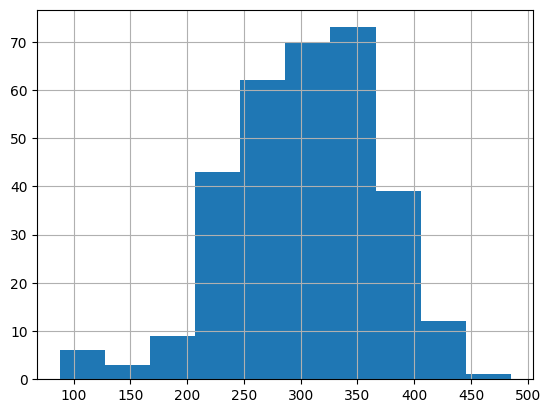

In [10]:
students_df["score"].hist()

In [13]:
students_df["gender"].value_counts()

0    160
1    158
Name: gender, dtype: int64

In [12]:
students_df["leader_flag"].value_counts()

0    301
1     17
Name: leader_flag, dtype: int64

In [14]:
students_df["support_flag"].value_counts()

0    314
1      4
Name: support_flag, dtype: int64

##### 生徒内で考慮が必要な特定ペア情報の確認

In [15]:
students_pair_df = pd.read_csv("./data/student_pairs.csv")
students_pair_df

,student_id1,student_id2
0,118,189
1,72,50
2,314,233


## 3. 最適化問題の定義と求解

In [16]:
import pulp

In [17]:
problem = pulp.LpProblem("ClassAssignmentProblem", pulp.LpMaximize)

#### 3-1. 最適化要件１：318人の生徒全員をそれぞれ1つのクラスに割り当てる
 - 生徒のリスト$S$, クラスのリスト$C$とする。
 - 生徒$s(\in S)$がクラス$c(\in C)$に割り当てられるかどうかを表す変数$x_{s,c}$
   $$
   x_{s,c} = \left\{
   \begin{array}{ll}
   1 & (\text{allocated}) \\ 
   0 & (\text{not allocated})
   \end{array}
   \right.
   $$
 - 各クラスへ割り当てられる
   $$ \sum_{c\in C} x_{s,c} = 1$$


In [19]:
num_of_class = 8
class_list = [c for c in range(num_of_class)]
class_list

[0, 1, 2, 3, 4, 5, 6, 7]

In [21]:
students_list = students_df["student_id"].to_list()
# students_list

In [27]:
# 生徒とクラスの全ペアのリスト
all_class_students_pair = [(s,c) for s in students_list for c in class_list]
# all_class_students_pair

# 生徒をどのクラスに割り当てるかを表す変数を定義
x = pulp.LpVariable.dicts("x",all_class_students_pair, cat="Binary")
# x
# {(1, 0): x_(1,_0),
#  (1, 1): x_(1,_1),
#  (1, 2): x_(1,_2),
#  (1, 3): x_(1,_3),
#  (1, 4): x_(1,_4),...}

In [29]:
# 最適化要件１の実装
for s in students_list:
    problem += pulp.lpSum([x[s,c] for c in class_list]) == 1

#### 3-2. 最適化要件２：各クラスの生徒数は39人以上、40人以下とする
 - 生徒のリスト$S$, クラスのリスト$C$とする
 - 生徒$s(\in S)$がクラス$c(\in C)$に割り当てられるかどうかを表す変数$x_{s,c}$
 - 満たすべき条件式：
    $$ \sum_{s \in S} x_{s,c} >= 39$$
    $$ \sum_{s \in S} x_{s,c} <= 40$$

In [30]:
#最適化要件２の実装
for c in class_list:
    problem += pulp.lpSum([x[s,c] for s in students_list]) >= 39
    problem += pulp.lpSum([x[s,c] for s in students_list]) <= 40

#### 3-3. 最適化要件３：各クラスの男子、女子生徒の人数はそれぞれ20人以下とする
 - 生徒のリスト$S$, クラスのリスト$C$とする
 - 男子生徒のリスト$S_{\text{male}}$, 女子生徒のリスト$S_{\text{female}}$とする。
 - 生徒$s(\in S)$がクラス$c(\in C)$に割り当てられるかどうかを表す変数$x_{s,c}$が満たすべき条件式
   $$ \sum_{s \in S_{\text{male}}} x_{s,c} <= 20$$
   $$ \sum_{s \in S_{\text{female}}} x_{s,c} <= 20$$

In [38]:
male_df = students_df[students_df["gender"] == 1]
male_list = male_df["student_id"].to_list()
print(f"num of male:{len(male_list)}")

num of male:158


In [40]:
female_df = students_df[students_df["gender"] == 0]
female_list = female_df["student_id"].to_list()
print(f"num of female:{len(female_list)}")

num of female:160


In [41]:
#最適化要件３の実装
for c in class_list:
    problem += pulp.lpSum([x[ms,c] for ms in male_list]) <= 20
    problem += pulp.lpSum([x[fs,c] for fs in female_list]) <= 20